反向传播的对象应该是$J(\theta)$，但$J(\theta)$作为累积折扣奖励无法写成$\theta$相关的函数形式。  
所以在$\nabla_{\theta}J(\theta)$求积分得到代理目标，对代理目标求梯度。

### 以下，重读mfrl策略梯度法部分

#### 平均状态价值重推导
状态价值定义：  
$v_{\pi}(s)=\mathbb{E}[G_t|S_t=s]$

$G_t = R_t + \gamma G_{t+1}$

$= R_t + \gamma (R_{t+1}+\gamma G_{t+2}) = R_t + \gamma R_{t+1} + \gamma^2 G_{t+2}$

$= \sum_{t=0}^\infty \gamma^t R_t$

所以：  
$v_{\pi}(s) = \mathbb{E}[\sum_{t=0}^{\infty} \gamma^t R_t|S_t=s]$

状态价值针对的是某个状态，如果对所有状态的改路进行加权，就得到了策略梯度法的目标，平均状态价值。

$\sum_{s\in\mathcal{S}} v_{\pi}(s) = \sum_{s\in\mathcal{S}} d(s)\mathbb{E}[\sum_{t=0}^{\infty}\gamma^t R_t | S_t =s]=\bar{v}_{\pi}$

#### 为什么状态分布$d(s)$可以选择和策略无关的分布，然后还可以作为目标来提升

策略是$\theta$的函数，目标只要是$\theta$的函数，就可以通过梯度上升来调整$\theta$提升。  
平均状态价值中，两部分，其中$v_{\pi}(s)$已经是$\theta$的函数了。因为策略决定了状态分布，也就决定了获取的奖励及状态价值。所以状态价值是$\theta$的函数。  
至于稳定状态分布$d$，理论上说，它和$\theta$有关，但不是一个可以通过$\theta$估计出来的值，而是一个长期迭代后收敛的值。所以，本身它也没法作为提升的一部分写进目标公式里，必须要通过蒙特卡洛法来模拟这个分布。  
另一方面，调整分布可以设定出不同的目标，让$\theta$朝着不同的方向更新。比如如果d是所有状态平均，可能这个要解决的问题本身就隐含了希望所有状态的分布是均匀的、同权的，设置目标为平均状态价值，就会让$\theta$朝着这个方向前进。

#### average state value 和average reward 有什么区别

average state value:  
$\bar{v}_{\pi}(s) = \sum_{s\in\mathcal{S}}d_{\pi}(s)v_{\pi}(s)$

average reward:  
$\bar{r}_{\pi}(s) = \sum_{s\in\mathcal{S}} d_{\pi}(s)r_{\pi}(s)$

猛一看，以为这俩好像没什么区别。好像就是换了个字母。实际上仔细想下状态价值和$r_{\pi}(s)$含义，就能发现区别。  
简单说，状态价值包含即时奖励和未来折扣奖励。也就是说，它的信息里包含了未来的奖励信息。  
而$r_{\pi}(s)$中仅有即时奖励，没有未来的奖励。

$v_{\pi}(s) = \mathbb{E}[R_t + \gamma G_{t+1}|S_t=s]$

$r_{\pi}(s) = \mathbb{E}[R_t | S_t=s]$

这个$r_{\pi}(s)$之前没出现过，所以突然出现有点迷

换个角度：  
$v_{\pi}(s) = \sum_{a\in\mathcal{A}}\pi(a|s,\theta)r(s,a) + \gamma\sum_{a\in\mathcal{A}}\pi(a|s,\theta)\sum_{s\in\mathcal{S}}p(s'|s,a)v_{\pi}(s')$

$r_{\pi}(s) = \sum_{a\in\mathcal{A}}\pi(a|s,\theta)r(s,a)$

也能看出来，$v_{\pi}(s)$包含了未来折扣奖励，$r_{\pi}(s)$只有即时奖励。

#### 怎么理解Box9.1证明的公式9.5

$\lim_{n\to\infty}\frac{1}{n}\mathbb{E}[\sum_{t=0}^{n-1}R_{t+1}]=\sum_{s\in\mathcal{S}}d_{\pi}(s)r_{\pi}(s)=\bar{r}_{\pi}$

看完证明回过头来说，公式讲的是，目标$\bar{r}_{\pi}$是累积奖励期望的均值。衡量的是，综合整个回合看，执行一个动作可以获得平均奖励。  
落到实际蒙特卡洛法任务上，一个任务运行了n步，收集奖励，加和取$\frac{1}{n}$的平均。运行m次，可以通过平均逼近期望。  
拿这个当目标，实际更关注每一步获得的奖励，希望每一步都能得到综合来看最高的即时奖励。而用$\bar{v}_{\pi}(s)$做目标，在意的是回合结束后得到的总奖励。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNet(nn.Module) :
    def __init__(self, state_dim, hidden_dim, action_dim) :
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_dim, action_dim, dtype=torch.float64)
        
    def forward(self, x) :
        l1 = self.fc1(x)
        a1 = F.relu(l1)
        l2 = self.fc2(a1)
        a2 = F.softmax(l2, dim=1)
        #print('x:',x.shape, "l1:", l1.shape, "a1:", a1.shape, "l2:", l2.shape, "a2:", a2.shape)
        return a2

In [2]:
import numpy as np

class Agent() :
    def __init__(self, state_dim, hidden_dim, action_dim, gamma) :
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim)
        # optimizer, lr,
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=0.001)
        
        self.observation_list = []
        self.actions_list = []
        self.reward_list = []
        self.gamma = gamma
        
    def take_action(self, state, env) :
        state = torch.tensor(state, dtype=torch.float64).unsqueeze(0)
        actions = self.policy_net(state).squeeze()
        action = env.action_space.sample(probability=actions.detach().numpy())
        #print(actions, action)
        return action

    def update(self, observation, action, reward, done) :
        self.observation_list.append(observation)
        self.actions_list.append(action)
        self.reward_list.append(reward)
        #print(actions, action, actions[action])

        if done :
            self.observation_list.reverse()
            self.actions_list.reverse()
            self.reward_list.reverse()
            
            step_num = len(self.observation_list)
            G = 0

            self.optimizer.zero_grad()
            total_target = 0
            for i in range(0, step_num) :
                observation = self.observation_list[i]
                reward = self.reward_list[i]
                
                #G += reward + self.gamma * G 
                G = reward + self.gamma * G

                state = torch.tensor(observation, dtype=torch.float64).unsqueeze(0)
                actions = self.policy_net(state).squeeze()
                
                target = - actions[self.actions_list[i]].log() * G
                #print(target)
                #target.backward()
                total_target += target
            total_target.backward()
            self.optimizer.step()

            self.observation_list = []
            self.actions_list = []
            self.reward_list = []

In [6]:
import os
os.environ['SDL_AUDIODRIVER'] = 'dummy'
os.environ['XDG_RUNTIME_DIR'] = '/home/youngsure/Code/tmp/'

import gymnasium as gym

# env init
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset(seed=0)
#print(observation)

# agent init
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
gamma = 0.98
agent = Agent(state_dim, hidden_dim, action_dim, gamma)

return_list = []

for i in range(1000) :
    observation, info = env.reset()#(seed=0)
    episode_over = False
    total_reward = 0

    while not episode_over:
        action = agent.take_action(observation, env)
        next_observation, reward, terminated, truncated, info = env.step(action)
        agent.update(observation, action, reward, terminated or truncated)
    
        total_reward += reward

        observation = next_observation
        episode_over = terminated or truncated

    return_list.append(total_reward)

    #print(f"Episode finished! Total reward: {total_reward}")
env.close()

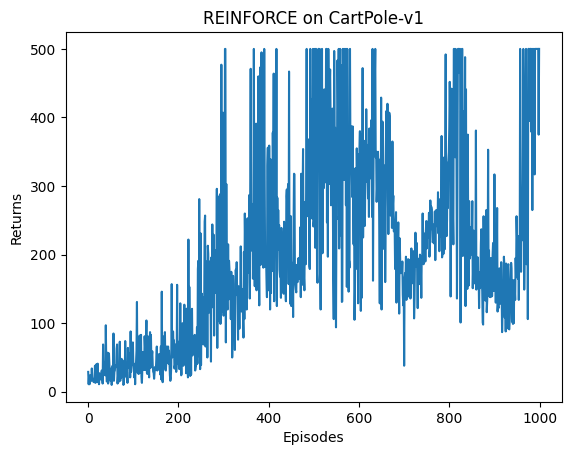

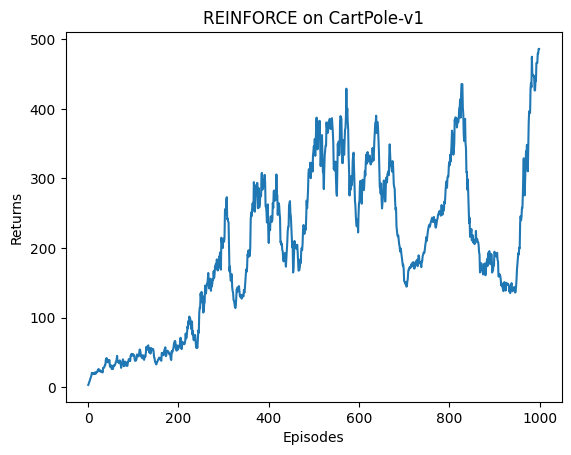

In [7]:
import matplotlib.pyplot as plt
env_name = "CartPole-v1"

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

def moving_average(targets, truncated_num) :
    truncated_sum = 0
    queue = []
    results = []
    for target in targets :
        queue.append(target)
        truncated_sum += target
        results.append(truncated_sum / truncated_num)
        if len(queue) == truncated_num :
            truncated_sum -= queue.pop(0)
            
    return results

mv_return = moving_average(return_list, 9)
#print(return_list, mv_return)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()